In [1]:
include("../Boolean.jl/bmodel.jl")
include("../Boolean.jl/utils.jl")
using StatsBase
using DataFrames, CSV, Statistics

In [2]:
function mutate(network::Array{Int64,2}, score::Float64, nr::Int)
    """Accepts a network (as a matrix), its fitness score (in [0,1]), and number of elements to replace `nr`;
    Returns a mutated network depending on the score;
    High fitness: low mutation; Low fitness: high mutation"""

    # replaces `nr` elements in `network` randomly 
    network[sample(1:9, nr , replace = false)] = rand(-1:1, nr)
    return network
end

function mutateMulti(network::Array{Int64,2}, score::Float64, n::Int)
    """Takes a network and a fitness score
    Returns `n` mutated matrices"""

    #number of elements in the network
    nm = size(network)[1]
    nm2 = nm^2
    # maps score (in [0, 1]) to 1:9
    nr = Int(round(nm2 -score*(nm2-1)))

    # vector of `n` matrices of size `nm x nm`
    # find a faster way
    nNets = [copy(network) for i in 1:n]
    # vectorized mutation
    mutate.(nNets, score, nr)
end

mutateMulti (generic function with 1 method)

In [3]:
# wrong function a in b
#=function ainb(a, b)
    "returns a boolean vector of with same length as `a`, where `1`s imply that `a[i]` is in `b`"
    n = length(a)
    x = zeros(Bool, n)
    for i in 1:n
        if a[i] in b
            x[i]=1
        end
    end
    return x
end =#

function getPscore(df)
    "returns the total probability of getting any of the states in `vars`; takes in the frequency df"
    vars = ["'001'";"'010'";"'100'"]
    # sum(df[ainb(df.states,vars),:frequency]) 
    freqList = df[ainb(df.states,vars),:frequency] 
    if length(freqList) < 3  
        return 0.
    else
        return prod(freqList)
    end
end

function dfFreqMulti(state_df::Array{DataFrame, 1}, cols::Array{Symbol, 1})
    "returns an array of dataframes containing the frequencies of states in each network "
    return [dfFreq(i, [:fin, :flag]) for i in state_df]
end

function ainb(a, b)
    "find index of a in b"
    [i for i in 1:length(a) if a[i] in b]
end

ainb (generic function with 1 method)

In [4]:
initNetwork

UndefVarError: UndefVarError: initNetwork not defined

In [5]:
# step1: loading and initial evaluation 
initNetwork = rand((-1:1), (3, 3));
# initNetwork = [0 -1 -1; 
#               -1 0 -1;
#               -1 -1 0]
df = dfFreq(
    asyncUpdateStates(initNetwork, 10000, 1000),
    [:fin, :flag])
pscore = getPscore(df)
df
pscore

0.0

In [26]:
pwd()

"/home/sharon/CELESTE/ACAD/CSB-Lab/GeneticNetwork/TopoFiles"

In [6]:
x = Float64[]
for i in 1:5
    # step2: mutate
    nNetworks = mutateMulti(initNetwork, pscore, 6)
    push!(nNetworks, initNetwork)
    
    # step3: evaluate 
    nResults = asyncUpdateStates.(nNetworks, 1000, 1000) # find states of all networks
    nFreqs = dfFreqMulti(nResults, [:fin, :flag]) # find frequencies of states (VECTORIZE)

    # step4: select
    pscores = getPscore.(nFreqs) # find pscores of all networks
    topScoreIndex = argmax(pscores) # find index of highest scoring network 

    initNetwork = nNetworks[topScoreIndex] # select the highest scoring network
    display(pscores[topScoreIndex]), display(initNetwork)
    push!(x, pscores[topScoreIndex])
end

0.0

3×3 Matrix{Int64}:
 1  0  0
 1  0  1
 1  0  0

0.0027769500000000003

3×3 Matrix{Int64}:
 -1   0  -1
 -1  -1   0
 -1   0   0

0.002557438

3×3 Matrix{Int64}:
 -1   0  -1
 -1  -1   0
 -1   0   0

0.002816712

3×3 Matrix{Int64}:
 -1   0  -1
 -1  -1   0
 -1   0   0

0.0025771550000000002

3×3 Matrix{Int64}:
 -1   0  -1
 -1  -1   0
 -1   0   0

In [7]:
initNetwork = [ 1  -1  -1;
1   1  -1;
-1   1  -1];
df = dfFreq(
asyncUpdateStates(initNetwork, 10000, 1000),
            [:fin, :flag])                


,states,flag,frequency
,Any,Any,Float64
1,'011',0,0.2467
2,'101',0,0.1229
3,'001',0,0.1259
4,'100',0,0.2555
5,'110',0,0.1223
6,'010',0,0.1267


In [8]:
using Plots

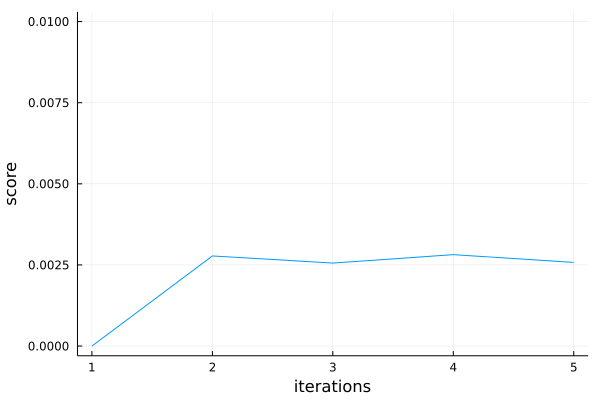

In [9]:
plot(x, xlabel="iterations", ylabel="score", legend=nothing, ylim=[0, 0.01])

In [10]:
initNetwork

3×3 Matrix{Int64}:
  1  -1  -1
  1   1  -1
 -1   1  -1

In [11]:
x

5-element Vector{Float64}:
 0.0
 0.0027769500000000003
 0.002557438
 0.002816712
 0.0025771550000000002

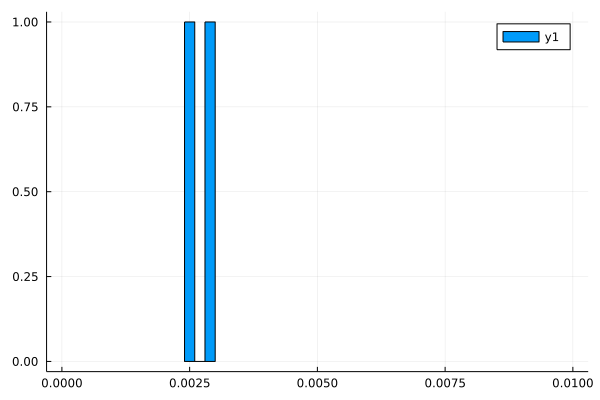

In [12]:
histogram(x[4:end], xlims=[0., 0.01])

In [13]:
df = dfFreq(
asyncUpdateStates(initNetwork, 10000, 1000),
[:fin, :flag])

,states,flag,frequency
,Any,Any,Float64
1,'001',0,0.1248
2,'011',0,0.248
3,'110',0,0.128
4,'100',0,0.2469
5,'010',0,0.1237
6,'101',0,0.1286


Section: writing matrix to topo

In [14]:
tNet = (rand((-1:1), (3, 3)))

3×3 Matrix{Int64}:
  1   0  1
  1   1  0
 -1  -1  0

In [15]:
function interaction2topo(tNet::AbstractMatrix, fname::Int)
    xi, yi, vi = findnz(sparse(tNet))
    lets = 'A':'Z'
    nmap = Dict(1=>1, -1=>2)
    io = open("net$(fname).topo", "w") 
    write(io,"Source\tTarget\tType\n")
    for i in 1:length(vi)
        # println("$(lets[xi[i]])\t$(lets[yi[i]])\t$(nmap[vi[i]])")  
        write(io, "$(lets[xi[i]])\t$(lets[yi[i]])\t$(nmap[vi[i]])\n")
    end
    close(io)
end
interaction2topo(tNet, 1)

In [16]:
# topo2interaction("writetest.topo")[1]

In [17]:
function solveRacipe(network::Matrix{Int64}, i::Int64)
    "Takes a network, and a reference number as input. Returns the frequency matrix of states"
    interaction2topo(network, i)
    run(`./RACIPE net$(i).topo`)
    dfr = CSV.read("net$(i)_solution.dat", DataFrame; header=0)
    n = (dfr |> names |> length) ÷ 2
    for i = 1:n 
        meani = mean(dfr[:, n+i])
        dfr[:, "Column$(2n+i)"] = (dfr[:, n+i] .- meani) .> 0.0
    end
    dfr[:, "fin"] =  "'" .* (.*([string.(Int.(dfr[:, 2n+i])) for i in 1:n]...)).*"'"
    dfFreq(dfr, [:fin])
end

solveRacipe (generic function with 1 method)

In [18]:
solveRacipe(initNetwork, 1234)

### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 9
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 9.872472s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.710327
2 -- 0.467674
3 -- 0.482788

-----------------Stability-----------------
#states -- Count
1 -- 52
2 -- 15
3 -- 0
4 -- 2
5 -- 0
6 -- 0
7 -- 1
8 -- 0
9 -- 0
10 -- 30
---> Actual running time : 9.872509 seconds ( 0.002742 hours)
The maximum running time is 23.500000.


,states,frequency
,String,Float64
1,'001',0.138539
2,'011',0.153652
3,'010',0.0403023
4,'110',0.214106
5,'111',0.110831
6,'100',0.183879
7,'101',0.115869
8,'000',0.0428212


In [19]:
df

,states,flag,frequency
,Any,Any,Float64
1,'001',0,0.1248
2,'011',0,0.248
3,'110',0,0.128
4,'100',0,0.2469
5,'010',0,0.1237
6,'101',0,0.1286


In [20]:
# step1: loading and initial evaluation 
# initNetwork = rand((-1:1), (3, 3));
initNetwork =  [0 -1 -1; 
              -1 0 -1;
              -1 -1 0]
df = solveRacipe(initNetwork, 1)
pscore = getPscore(df)
pscore

### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- B
2 -- A
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 6
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
B	1.000000
A	1.000000
C	1.000000
100% 1.216236s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.378788
2 -- 0.439394
3 -- 0.463636

-----------------Stability-----------------
#states -- Count
1 -- 47
2 -- 48
3 -- 4
4 -- 0
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 1
---> Actual running time : 1.216275 seconds ( 0.000338 hours)
The maximum running time is 23.500000.


0.015221303948576674

In [21]:
x = Float64[]
for i in 1:5
    # step2: mutate
    nNetworks = mutateMulti(initNetwork, pscore, 6)
    push!(nNetworks, initNetwork)
    
    # step3: evaluate 
    # find states of all networks 
    nFreqs = [solveRacipe(net, 1) for net in nNetworks]

    # step4: select
    pscores = getPscore.(nFreqs) # find pscores of all networks
    topScoreIndex = argmax(pscores) # find index of highest scoring network 

    initNetwork = nNetworks[topScoreIndex] # select the highest scoring network
    display(pscores[topScoreIndex]), display(initNetwork)
    push!(x, pscores[topScoreIndex])
end

### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- C
2 -- A
3 -- B
-------------------------------------------
Total number of genes = 3
Total number of regulations = 6
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
C	1.000000
A	1.000000
B	1.000000
100% 4.528111s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.366142
2 -- 0.429134
3 -- 0.704724

-----------------Stability-----------------
#states -- Count
1 -- 65
2 -- 18
3 -- 1
4 -- 1
5 -- 0
6 -- 1
7 -- 0
8 -- 0
9 -- 0
10 -- 14
---> Actual running time : 4.528134 seconds ( 0.001258 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
---------------------------------------

0.012757611466841368

3×3 Matrix{Int64}:
  0  -1  -1
 -1   0  -1
 -1  -1   0

100% 0.766553s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.521739
2 -- 0.478261
3 -- 0.559006

-----------------Stability-----------------
#states -- Count
1 -- 44
2 -- 52
3 -- 3
4 -- 1
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 0
---> Actual running time : 0.766580 seconds ( 0.000213 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 0.513981s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.549020
2 -- 0.598039
3 -- 0.552288

-----------------Stability-----------------
#states -- Count
1 -- 98
2 -- 2
3 -- 0
4 -- 

0.0096002488052924

3×3 Matrix{Int64}:
  0  -1  -1
 -1   0  -1
 -1  -1   0

100% 0.988910s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.388889
2 -- 0.525641
3 -- 0.493590

-----------------Stability-----------------
#states -- Count
1 -- 61
2 -- 36
3 -- 1
4 -- 0
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 2
---> Actual running time : 0.988935 seconds ( 0.000275 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 6
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 0.995753s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.637500
2 -- 0.608333
3 -- 0.462500

-----------------Stability-----------------
#states -- Count
1 -- 82
2 -- 17
3 -- 0
4 --

100% 0.605417s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.522727
2 -- 0.500000
3 -- 0.473485

-----------------Stability-----------------
#states -- Count
1 -- 69
2 -- 30
3 -- 1
4 -- 0
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 0
---> Actual running time : 0.605442 seconds ( 0.000168 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- C
3 -- B
-------------------------------------------
Total number of genes = 3
Total number of regulations = 4
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
C	1.000000
B	1.000000
100% 0.547318s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.538793
2 -- 0.491379
3 -- 0.715517

-----------------Stability-----------------
#states -- Count
1 -- 84
2 -- 16
3 -- 0
4 --

0.011171972279170387

3×3 Matrix{Int64}:
  0  -1  -1
 -1   0  -1
 -1  -1   0

### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- C
2 -- A
3 -- B
-------------------------------------------
Total number of genes = 3
Total number of regulations = 4
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
C	1.000000
A	1.000000
B	1.000000
100% 1.364628s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.480645
2 -- 0.529032
3 -- 0.741935

-----------------Stability-----------------
#states -- Count
1 -- 80
2 -- 15
3 -- 0
4 -- 0
5 -- 1
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 4
---> Actual running time : 1.364651 seconds ( 0.000379 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- B
2 -- A
3 -- C
----------------------------------------

0.014337484475177065

3×3 Matrix{Int64}:
  0  -1  -1
 -1   0  -1
 -1  -1   0

100% 0.711654s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.483871
2 -- 0.535484
3 -- 0.545161

-----------------Stability-----------------
#states -- Count
1 -- 54
2 -- 37
3 -- 9
4 -- 0
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 0
---> Actual running time : 0.711681 seconds ( 0.000198 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- B
2 -- A
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 6
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
B	1.000000
A	1.000000
C	1.000000
100% 0.490819s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.620000
2 -- -nan
3 -- 0.630000

-----------------Stability-----------------
#states -- Count
1 -- 100
2 -- 0
3 -- 0
4 -- 0
5

100% 0.733843s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.536688
2 -- 0.320755
3 -- 0.295597

-----------------Stability-----------------
#states -- Count
1 -- 56
2 -- 32
3 -- 9
4 -- 3
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 0
---> Actual running time : 0.733863 seconds ( 0.000204 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 5
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 0.269476s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.620000
2 -- 0.570000
3 -- 0.510000

-----------------Stability-----------------
#states -- Count
1 -- 100
2 -- 0
3 -- 0
4 --

0.011145358870210367

3×3 Matrix{Int64}:
  0  -1  -1
 -1   0  -1
 -1  -1   0

100% 3.227447s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.456044
2 -- 0.406593
3 -- 0.507326

-----------------Stability-----------------
#states -- Count
1 -- 61
2 -- 26
3 -- 8
4 -- 0
5 -- 1
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 4
---> Actual running time : 3.227481 seconds ( 0.000897 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- B
2 -- A
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 6
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
B	1.000000
A	1.000000
C	1.000000
100% 1.302524s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.389205
2 -- 0.536932
3 -- 0.423295

-----------------Stability-----------------
#states -- Count
1 -- 57
2 -- 31
3 -- 9
4 --

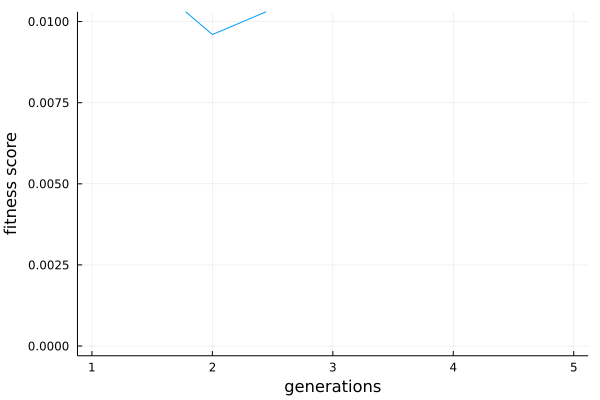

In [22]:
plot(x, xlabel="generations", ylabel="fitness score", legend=nothing, ylim=[0, 0.01])

In [23]:
initNet = rand((-1:1), (3, 3));
nFreqs = [solveRacipe(initNet, 1)[:, 2] for i in 1:100]

### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 3.889436s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.563415
2 -- 0.407317
3 -- 0.445528

-----------------Stability-----------------
#states -- Count
1 -- 59
2 -- 33
3 -- 0
4 -- 0
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 8
---> Actual running time : 3.889455 seconds ( 0.001080 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
----------------------------------------

100% 2.021145s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.449704
2 -- 0.494083
3 -- 0.445759

-----------------Stability-----------------
#states -- Count
1 -- 67
2 -- 25
3 -- 4
4 -- 0
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 4
---> Actual running time : 2.021180 seconds ( 0.000561 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 2.003144s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.461310
2 -- 0.476190
3 -- 0.452381

-----------------Stability-----------------
#states -- Count
1 -- 67
2 -- 21
3 -- 8
4 --

100% 2.643125s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.462500
2 -- 0.453125
3 -- 0.460417

-----------------Stability-----------------
#states -- Count
1 -- 73
2 -- 22
3 -- 1
4 -- 0
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 4
---> Actual running time : 2.643144 seconds ( 0.000734 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 2.260485s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.532544
2 -- 0.473373
3 -- 0.469428

-----------------Stability-----------------
#states -- Count
1 -- 63
2 -- 28
3 -- 5
4 --

100% 3.034951s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.545024
2 -- 0.469194
3 -- 0.437599

-----------------Stability-----------------
#states -- Count
1 -- 53
2 -- 35
3 -- 4
4 -- 0
5 -- 0
6 -- 1
7 -- 0
8 -- 0
9 -- 0
10 -- 7
---> Actual running time : 3.034982 seconds ( 0.000843 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 3.334778s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.513636
2 -- 0.425000
3 -- 0.345455

-----------------Stability-----------------
#states -- Count
1 -- 63
2 -- 25
3 -- 1
4 --

### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 3.331903s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.444444
2 -- 0.439394
3 -- 0.368687

-----------------Stability-----------------
#states -- Count
1 -- 63
2 -- 26
3 -- 3
4 -- 1
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 7
---> Actual running time : 3.331934 seconds ( 0.000926 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
----------------------------------------

100% 2.038138s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.489691
2 -- 0.469072
3 -- 0.438144

-----------------Stability-----------------
#states -- Count
1 -- 59
2 -- 30
3 -- 5
4 -- 0
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 6
---> Actual running time : 2.038165 seconds ( 0.000566 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 2.700499s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.556886
2 -- 0.398204
3 -- 0.453094

-----------------Stability-----------------
#states -- Count
1 -- 61
2 -- 31
3 -- 5
4 --

100% 2.145717s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.563218
2 -- 0.419540
3 -- 0.455939

-----------------Stability-----------------
#states -- Count
1 -- 63
2 -- 30
3 -- 2
4 -- 0
5 -- 1
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 4
---> Actual running time : 2.145754 seconds ( 0.000596 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 2.989344s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.589372
2 -- 0.403382
3 -- 0.394525

-----------------Stability-----------------
#states -- Count
1 -- 59
2 -- 28
3 -- 5
4 --

100% 3.069719s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.514085
2 -- 0.410798
3 -- 0.374022

-----------------Stability-----------------
#states -- Count
1 -- 60
2 -- 30
3 -- 1
4 -- 0
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 9
---> Actual running time : 3.069750 seconds ( 0.000853 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 2.550270s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.470109
2 -- 0.486413
3 -- 0.452899

-----------------Stability-----------------
#states -- Count
1 -- 69
2 -- 21
3 -- 3
4 --

### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 1.651440s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.399390
2 -- 0.442073
3 -- 0.363821

-----------------Stability-----------------
#states -- Count
1 -- 72
2 -- 22
3 -- 1
4 -- 0
5 -- 1
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 4
---> Actual running time : 1.651457 seconds ( 0.000459 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
----------------------------------------

100% 3.241476s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.617512
2 -- 0.398618
3 -- 0.396313

-----------------Stability-----------------
#states -- Count
1 -- 63
2 -- 21
3 -- 6
4 -- 1
5 -- 0
6 -- 0
7 -- 0
8 -- 0
9 -- 0
10 -- 9
---> Actual running time : 3.241498 seconds ( 0.000900 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
100% 1.766671s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.474843
2 -- 0.496855
3 -- 0.473795

-----------------Stability-----------------
#states -- Count
1 -- 67
2 -- 28
3 -- 2
4 --

100% 1.711889s
-------------------T_test------------------
Gene_ID -- Probs_over_T
1 -- 0.513072
2 -- 0.454248
3 -- 0.527233

-----------------Stability-----------------
#states -- Count
1 -- 61
2 -- 30
3 -- 8
4 -- 0
5 -- 0
6 -- 0
7 -- 0
8 -- 1
9 -- 0
10 -- 0
---> Actual running time : 1.711911 seconds ( 0.000476 hours)
The maximum running time is 23.500000.
### Warning: Uniform distribution is used.

-------------------------------------------
The topo file contains the following genes:
Gene_ID -- Gene_Name
1 -- A
2 -- B
3 -- C
-------------------------------------------
Total number of genes = 3
Total number of regulations = 7
-------------------------------------------
Amplification of the parameter ranges (production rates and thresholds)
A	1.000000
B	1.000000
C	1.000000
11% 0.136333s

InterruptException: InterruptException:

In [25]:
pwd()

"/home/sharon/CELESTE/ACAD/CSB-Lab/GeneticNetwork/TopoFiles"